# Predicting Depression Based on Musical Taste

# TL;DR
- This project aims to develop machine learning models to predict depression based on a free survey dataset (Music x Mental Health Traits), which contains responses from over 700 individuals worldwide about their music preferences and mental health traits.
- Depression is assumed as a binary variable (yes/no), therefore five classification models are explored: K-Nearest Neighbors, Naive Bayes, Decision Tree, Support Vector Machine, and Linear Discriminant Analysis. The variables used as predictors include - but are not limited to - age, frequency listening to multiple genres, and whether individuals play an instrument.
- All models performance ranged from moderate to relatively consisent, with K-Nearest Neighbors being the best choice in terms of performance, interpretability, and capturing the non-linear relationship between mental health and music preferences.
- Even though all models perform somewhat decently, mental health is a complex topic and the assumptions underlying the models are simplistic, therefore this attempt would benefit from more/better data and enhanced models. Additionally, implementing such models would require evaluating the ethical implications.

Having a background in psychology and having played guitar for over 15 years, music and mental health are two topics near and dear to me. It's well known that mental disorders affect millions worldwide, and their impact on individuals and society is significant. While the causes of mental disorders are complex and multifaceted, researchers have long recognized that environmental factors, such as social and cultural influences, can play a role in their development. Therefore, this post aims to explore **whether machine learning algorithms can predict depression based on music preferences and streaming behaviors**.

This post is roughly divided as follows:
1. Explore the data
2. Transform the data
3. Build the models

## Explore The Data

We will use the **programming language, Python**, to explore and transform the **MxMT (Music x Mental Health Traits) dataset**, which is a survey dataset that contains responses from over 700 individuals about their music preferences and mental health traits. The survey was conducted online from August to November 2022, it was mostly distributed through online channels (such as Reddit), and did not limit participants by age or location.

Below is a snippet of the raw dataset as well as some graphics exploring missingness in the data, the distribution of some of the main (numerical) columns, and the correlation among variables. The full dataset can also be accessed online for free (https://www.kaggle.com/datasets/catherinerasgaitis/mxmh-survey-results).

In [114]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # fundamental visualization
import seaborn as sns # advanced visualization built on top of matplotlib

In [115]:
df = pd.read_csv("mxmh_survey_results.csv")

In [116]:
# set max_columns option to None to show all columns
pd.set_option('display.max_columns', None)

df.head()

,Timestamp,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,BPM,Frequency [Classical],Frequency [Country],Frequency [EDM],Frequency [Folk],Frequency [Gospel],Frequency [Hip hop],Frequency [Jazz],Frequency [K pop],Frequency [Latin],Frequency [Lofi],Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects,Permissions
0,8/27/2022 19:29:02,18.0,Spotify,3.0,Yes,Yes,Yes,Latin,Yes,Yes,156.0,Rarely,Never,Rarely,Never,Never,Sometimes,Never,Very frequently,Very frequently,Rarely,Never,Very frequently,Sometimes,Very frequently,Never,Sometimes,3.0,0.0,1.0,0.0,NaN,I understand.
1,8/27/2022 19:57:31,63.0,Pandora,1.5,Yes,No,No,Rock,Yes,No,119.0,Sometimes,Never,Never,Rarely,Sometimes,Rarely,Very frequently,Rarely,Sometimes,Rarely,Never,Sometimes,Sometimes,Rarely,Very frequently,Rarely,7.0,2.0,2.0,1.0,NaN,I understand.
2,8/27/2022 21:28:18,18.0,Spotify,4.0,No,No,No,Video game music,No,Yes,132.0,Never,Never,Very frequently,Never,Never,Rarely,Rarely,Very frequently,Never,Sometimes,Sometimes,Rarely,Never,Rarely,Rarely,Very frequently,7.0,7.0,10.0,2.0,No effect,I understand.
3,8/27/2022 21:40:40,61.0,YouTube Music,2.5,Yes,No,Yes,Jazz,Yes,Yes,84.0,Sometimes,Never,Never,Rarely,Sometimes,Never,Very frequently,Sometimes,Very frequently,Sometimes,Never,Sometimes,Sometimes,Never,Never,Never,9.0,7.0,3.0,3.0,Improve,I understand.
4,8/27/2022 21:54:47,18.0,Spotify,4.0,Yes,No,No,R&B,Yes,No,107.0,Never,Never,Rarely,Never,Rarely,Very frequently,Never,Very frequently,Sometimes,Sometimes,Never,Sometimes,Very frequently,Very frequently,Never,Rarely,7.0,2.0,5.0,9.0,Improve,I understand.


<AxesSubplot:>

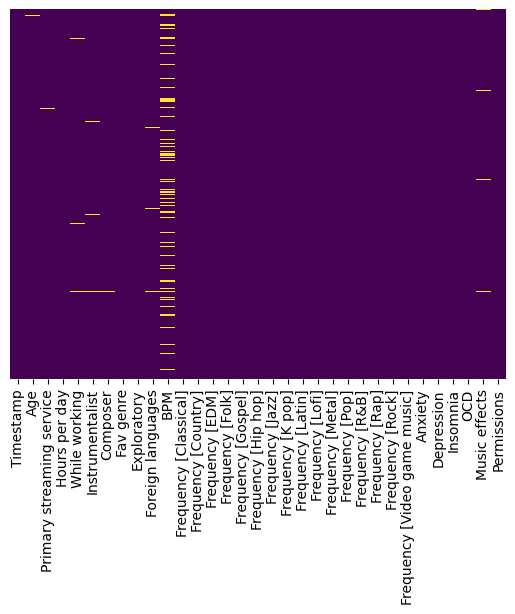

In [117]:
# assessing null values
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Hours per day'}>],
       [<AxesSubplot:title={'center':'Anxiety'}>,
        <AxesSubplot:title={'center':'Depression'}>],
       [<AxesSubplot:title={'center':'Insomnia'}>,
        <AxesSubplot:title={'center':'OCD'}>]], dtype=object)

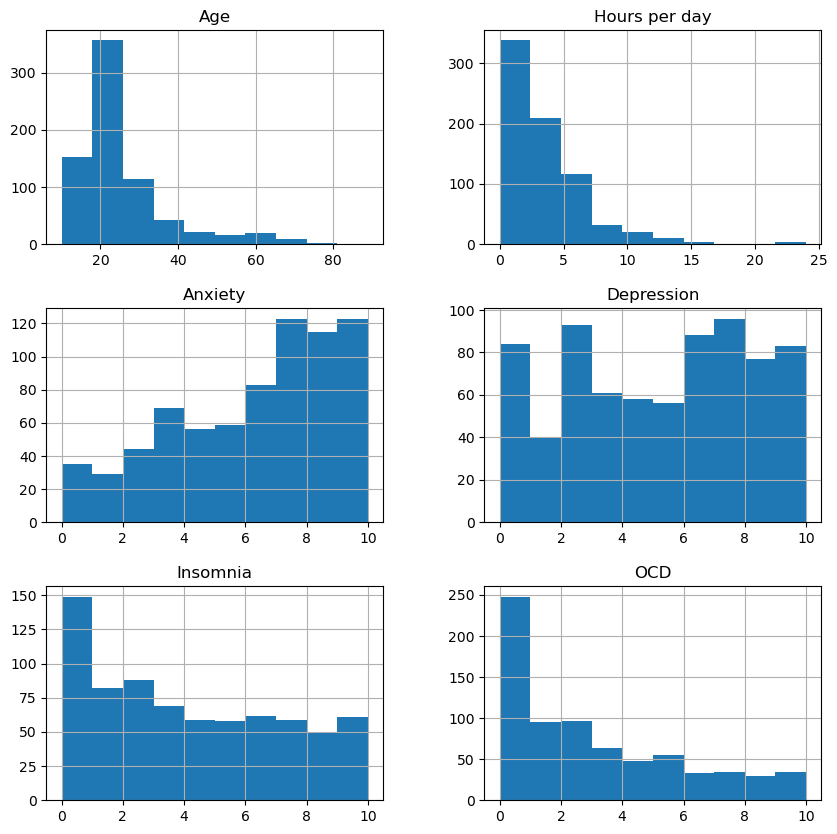

In [118]:
# plotting histogram for numerical columns
df[['Age', 'Hours per day', 'Anxiety', 'Depression', 'Insomnia', 'OCD']].hist(figsize=(10, 10), bins=10)

<AxesSubplot:>

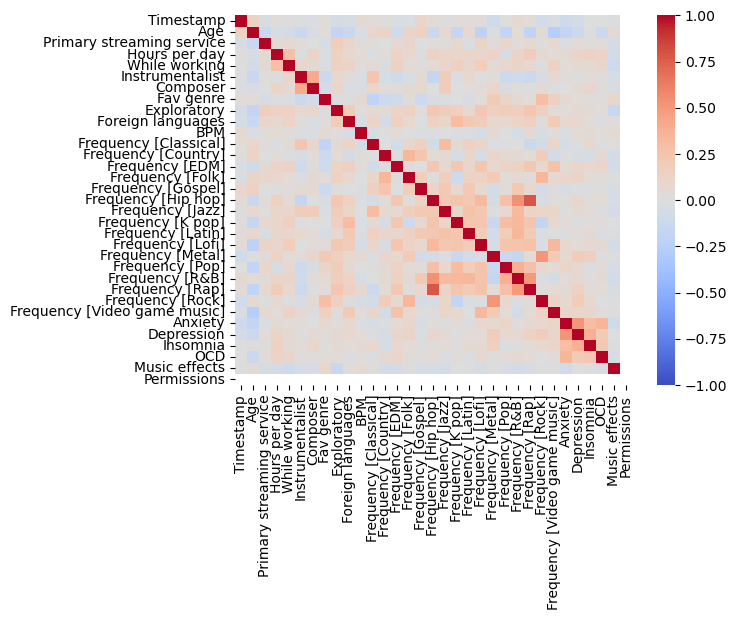

In [119]:
# plotting correlation matrix
from sklearn.preprocessing import LabelEncoder

# loop over all columns in the dataframe
for column in df.columns:
    # check if the column is not of float data type
    if df[column].dtype != 'float64':
        # apply label encoder to the column
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        
sns.heatmap(df.corr()
            , cmap='coolwarm'
            , vmin=-1, vmax=1
            , xticklabels=df.corr().columns.values
            , yticklabels=df.corr().columns.values)

From the exploratory section, we can see that the dataset contains 33 variables which can be roughly divided in three blocks: Demographics/behaviors, music genres, and mental health. The dataset seems complete for the most part, with the exception of the BPM variable which has a higher degree of missingness. Most respondents are 18-30 years old, anxiety and depression are the most common disorders among them, and only a minority of variables seem to be highly correlated (e.g., mental disorders are highly correlated amongst themselves as well as some music genres).

## Transforming The Data

Based on the findings from the exploratory section, below are the actions implemented to preprocess the data:
- Create a dataframe that includes only the variables of interest
- Remove null values
- Deal with outliers in the daily hours spent listening to music
- Transform dependent variable (depression, originally 1-10) to binary (1-5 will be 0, 6-10 will be 1)
- Encode categorical columns (including the target variable)

Something important to highlight is the decision to **transform depression from a 1-10 scale to a binary (0-1) variable**. Even though mental disorders arguably have varying degrees to them, this decision is made to resemble how a diagnosis would be made: People who fit certain criteria are diagnosed with a disorder (in this case, thos who responded 6-10 are labeled as having a depression). This may not be the best for real life scenarios, but can increase the interpretability and can pave the way for follow-up analysis (more of this discussion can be found at the end of the post).

It is also worthnoting that **not all variables are used as predictors**. The variables are narrowed down through feature selection - i.e., experimenting with adding and removing variables until an optimal performance is achieved.

The resulting dataset - which is then used to build and train the models - can be downloaded in the dataset button at the top of this page.

In [120]:
# read in data again in case any changes were made during the EDA
df = pd.read_csv("mxmh_survey_results.csv")

# create new dataframe excluding variables that are NOT of interest
df = df.drop(['Timestamp', 'BPM', 'Anxiety', 'OCD', 'Insomnia', 'Permissions'
              , 'Music effects', 'Fav genre', 'Primary streaming service'
             ], axis=1)

# remove all rows with null values
df = df.dropna()

# treat outliers in the hours spent listening to music
## some people said they spend over 10 hours listening to music
## while this is indeed possible, I will treat it as trolls or simply incorrect answers
## I will use an arbitrary cut off value - anything above 10 hours will be limited to 10 hours
df['Hours per day'] = df['Hours per day'].apply(lambda x: 10 if x > 10 else x)

# recode depression levels 0-10 to a binary variable
# anything from 0-5 will be 0, anything from 6-10 will be 1
df['Depression'] = df['Depression'].apply(lambda x: 0 if x <= 6 else 1)

# encode categorical columns
from sklearn.preprocessing import LabelEncoder

# create label encoder instance
lb_make = LabelEncoder()

# loop over all columns in the dataframe
for column in df.columns:
    # check if the column is not of float data type
    if df[column].dtype != 'float64':
        # apply label encoder to the column
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        
# convert mental disorders to a category        
df['Depression'] = lb_make.fit_transform(df['Depression'])

Text(0, 0.5, 'Count')

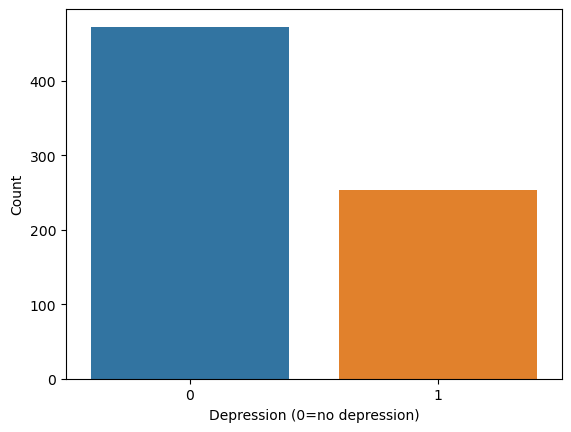

In [123]:
# plotting new distribution of dependent variable
sns.countplot(x='Depression', data=df)

# Adding labels to the plot
plt.xlabel('Depression (0=no depression)')
plt.ylabel('Count')

## Build The Models

Once the data has been transfomed and arranged as needed, we can talk about building our predictive models. First, we will begin by splitting the data into a training set and a testing set. Then, we will proceed with the actual fitting. Given that the outcome variable - the one we want to predict - is binary, the problem at hand is suiting for classification models. With that in mind, these are the models that will be tested:
- K-Nearest Neighbors
- Naive Bayes
- Decision Tree
- Support Vector Machines
- Linear Discriminant Analysis

Lastly, once all models are fitted, we will compare them and see which performs best in terms of predicting depression (if any!). Some common metrics to evaluate classification models include accuracy and the F1 score, but given that the classes of the outcome variable (depression) are somewhat unbalanced - meaning that there are significantly more people without depression - the Macro F1 score is a better metric to determine each model's performance.


In [122]:
## SPLIT THE DATA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# split the dataframe into a feature matrix and a target vector
X = df.drop('Depression', axis=1)  # selecting everything but the target variable
y = df['Depression']  # selecting the target variable

# create instance with scaler function
scaler = StandardScaler()

# rescale independent variables
X = scaler.fit_transform(X)

#30% of the train.csv is assigned to the validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 


## K-NEAREST NEIGHBORS
from sklearn.neighbors import KNeighborsClassifier

# create instance with knn function and parameter
knn = KNeighborsClassifier(n_neighbors=19, weights='distance')

# fit the model
knn.fit(X_train, y_train)


## NAIVE BAYES
from sklearn.naive_bayes import GaussianNB

# generate instance with naive bayes function
nb_model = GaussianNB()

# fit model
nb_model.fit(X_train, y_train)


## DECISION TREE
from sklearn.tree import DecisionTreeClassifier

# initialize the decision tree classifier
clf = DecisionTreeClassifier()

# fit the classifier to the training data
clf.fit(X_train, y_train)


## SUPPORT VECTOR MACHINE
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# create an SVM classifier object
svc = svm.SVC()

# define the parameter grid to search over
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.1, 1, 10]
}

# create a GridSearchCV object with the SVM classifier and parameter grid
grid_search = GridSearchCV(svc, param_grid, scoring='f1_macro', cv=5)

# fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)

# get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# create an SVM classifier with the best parameters
svc = svm.SVC(**best_params)

# fit the model on the training data using the best parameters
svc.fit(X_train, y_train)


## LINEAR DISCRIMINANT ANALYSIS
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# create instance with linear discriminant analysis function
lda = LinearDiscriminantAnalysis()

# fit model
lda.fit(X_train, y_train)

# running a cross validation after having tuned each model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score

# define the classifiers
classifiers = [
    KNeighborsClassifier(n_neighbors=19, weights='distance'),
    DecisionTreeClassifier(),
    SVC(C=10, gamma=0.1, kernel='rbf'),
    GaussianNB(),
    LinearDiscriminantAnalysis()
]

# iterate over classifiers and get scores
for clf in classifiers:
    scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
    f1_scores = cross_val_score(clf, X, y, cv=10, scoring='f1_macro')
    print("Accuracy: %0.2f (+/- %0.2f) Macro F1 score: %0.2f (+/- %0.2f) [%s]" % (scores.mean()
                                                                            , scores.std()
                                                                            , f1_scores.mean()
                                                                            , f1_scores.std()
                                                                            , clf.__class__.__name__))

Accuracy: 0.65 (+/- 0.03) Macro F1 score: 0.53 (+/- 0.04) [KNeighborsClassifier]
Accuracy: 0.57 (+/- 0.05) Macro F1 score: 0.54 (+/- 0.06) [DecisionTreeClassifier]
Accuracy: 0.65 (+/- 0.04) Macro F1 score: 0.57 (+/- 0.05) [SVC]
Accuracy: 0.60 (+/- 0.04) Macro F1 score: 0.57 (+/- 0.03) [GaussianNB]
Accuracy: 0.64 (+/- 0.02) Macro F1 score: 0.49 (+/- 0.02) [LinearDiscriminantAnalysis]


The models result in varying levels of performance, bias and variance, flexibility, and interpretability. Based on the accuracy and the standard deviation, the models range from moderate to relatively consistent. In term of flexibility and interpretability, K-Nearest Nieghbors and Decision Trees tend to be the most flexible and interpretable. Related to the previous point, since we are dealing with a nuanced problem such as predicting mental disorders, it is likely the models that assume linearity (Support Vectors, Naive Bayes, Linear Discriminant Analysis) introduce greater bias than those that are able to better capture non-linear relationships (KNN and Decision Trees).

With all that said and done, **I would choose K-Nearest Neighbors as the best performing model**: It has the highest accuracy, it has one of the highest Macro F1 scores, it is highly interpretable, it is highly flexible, it has relatively low variance and likely introduces less bias due to its ability to capture non-linear relationships.

## In Conclusion

While the KNN model reaches somewhat decent levels of predictive power, it's still a 60-70% performance for predicting two categories - at which point, you might be better off flipping a coin and assigning depression based on that. 

But even more than each model's performance, for me, the core question is: Can we really predict mental disorders? Mental health is already nuanced as is, so reducing it to a binary status - either you're depressed or not - based on arbitrary numbers is already a questionable choice. A better route would be to use a holistic dependent variable that encompasses self-reported measures along with professional assessments and even physiological metrics.

Related to mental health being a multifaceted phenomena, these models rely on a limited amount of variables, therefore it is possible that depression is not being properly captured through the selected dependent variables (e.g., perhaps an ideal model needs to include Beats Per Minute or an individual's primary streaming service).

Additionally, even though the data seems more or less normally distributed, there was little control over the sample which further threatens any generalizations that can come from this analysis. In this regard, the ideal alternative would be to make the sampling method as random as possible while accounting for sociocultural and demographic variables.

And lastly, imagine if we created a more accurate model, would we still want to predict mental disorders based on music taste? This could entail severe ethical implications - from endangering freedom of speech to wanting to access private data in the name of mental health.

In conclusion, **even though the machine learning models are relatively consistent when it comes to predicting depression, ultimately, the assumptions underlying the variables are reductionist and fail to capture the complex topics that are music and mental health**. Music is intertwined with sociocultural practices and it is hard to encompass all of the aspects involved in a short survey. As for mental health, self reported measures are always debatible - add to that the fact that these models reduced depression to a binary scale, then you have a much more dubious outcome variable. Should a follow-up analysis be conducted, I would recommend fully fleshing out these concepts and having more control (while randomizing) over the sampling method.